In [355]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os
import cv2
import math
import random

%matplotlib inline 

IMAGE_DIMS = (52 , 52 , 1)

## Загрузка шаблона карты

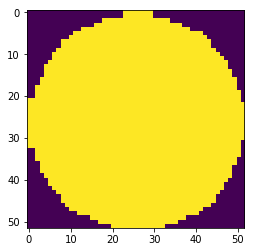

In [3]:
wafer_map = pd.read_pickle('test_wafer_map.pkl')
test = cv2.resize(wafer_map.waferMap, dsize=(IMAGE_DIMS[0],IMAGE_DIMS[1]), 
                  interpolation=cv2.INTER_NEAREST) 

## 2 - паттерн
## 1 - фон
## 0 - область, где нет ничего
test[test == 2] = 1

## проверка
plt.imshow(test);

# Генератор пилообразных прямых 

In [56]:
def sawtooth_line(XC_, YC_, L0_, angle_, line_count, pattern_type, lam_poisson=0.2):
    size = XC_.shape[0]
    df = [None] * size
    
    for n in range(size):   
        # иниицализация параметров прямой
        L0 = L0_[n]
        XC = XC_[n]
        YC = YC_[n]
        angle = angle_[n]
        ## создадим тестовый полигон
        test = cv2.resize(wafer_map.waferMap, dsize=(IMAGE_DIMS[0],IMAGE_DIMS[1]), 
                  interpolation=cv2.INTER_NEAREST)
        ## 2 - паттерн
        ## 1 - фон
        ## 0 - область, где нет ничего
        test[test == 2] = 1
        COLOR_SCALE = 2

        ## параметры уравнения
        def delta_(x,y):
            return int(math.sqrt(x**2 + y**2))
        delta = np.vectorize(delta_)

        L = L0 - np.sum(delta(XC, YC)[1:])
        N = 200
        x0, y0 = 0, 0

        ## кусочное построение пилообразной прямой 
        for i in range(line_count):
            ## случайное удлинение или укорочение отрезка
            import random
            rand = random.randint(-1,0)
            scale = 0.4
            t = np.linspace(0, L//(line_count + rand*scale), N)

            xc = XC[i]
            yc = YC[i]
            X = np.cos(angle[i]) * t + xc + x0
            Y = np.sin(angle[i]) * t + yc + y0
            X_ = np.around(X)
            Y_ = np.around(Y)

            x_prev, y_prev = x0, y0

            for j in range(X_.shape[0]):
                x = int(X_[j])
                y = int(Y_[j])
                if j == 0:
                    ## первая точка прямой 
                    x_first, y_first = x, y

                try:
                    if test[x,y] == 1:
                        test[x,y] = COLOR_SCALE
                        x0, y0 = x, y
                except IndexError:
                    break


            ## сшивка прямых        
            if i != 0:
                ## уравнение прямой сшивки
                k = (y_prev - y_first) / (x_prev - x_first+1e-06)
                b = y_first - k*x_first
                X = np.linspace(x_prev, x_first, 20)
                Y = k * X + b
                X_ = np.around(X)
                Y_ = np.around(Y)
                for j in range(X_.shape[0]):
                    x = int(X_[j])
                    y = int(Y_[j])
                    try:
                        if test[x,y] == 1:
                            test[x,y] = COLOR_SCALE
                    except IndexError:
                        break


#         kernel = np.ones((3,3), np.uint8)
        kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
        test = cv2.dilate(test,kernel,iterations = 1)
        test = cv2.morphologyEx(test, cv2.MORPH_CLOSE, kernel)
            
        noise_img = test.copy()
        mask = np.random.randint(0, 2, size=noise_img.shape).astype(np.bool)
        mask[noise_img == 0] = False
        r = np.random.poisson(lam=lam_poisson, size=noise_img.shape)
        r[r==0] = 1
        r[r>2] = 2
        noise_img[mask] = r[mask]
        
#         kernel = np.ones((3,3), np.uint8)
        kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
        noise_img = cv2.morphologyEx(noise_img, cv2.MORPH_CLOSE, kernel)

        df[n] = [noise_img, pattern_type]
        
    return pd.DataFrame(df, columns=['waferMap', 'failureType'])


# Генерация кривых

## Пилообразные прямые 

In [349]:
%%time
## число синтезированных карт
N_POINTS = 15

## суммарная длина отрезка 
L0 = np.random.randint(0.6*IMAGE_DIMS[0], 0.65*IMAGE_DIMS[0], size=N_POINTS)

## X координата старта прямой
XC = np.random.randint(0.5*IMAGE_DIMS[0], 0.7*IMAGE_DIMS[0], size=N_POINTS)
## смещение по x для старта следующей прямой
delta_xc = np.random.randint(0.02*IMAGE_DIMS[0], 0.05*IMAGE_DIMS[0], size=N_POINTS)
np.random.shuffle(delta_xc)
XC = np.vstack((XC, delta_xc))
## merge под формат генератора
xc = np.array([[XC[0,i], XC[1,i]] for i in range(XC.shape[1])])

## Y координата старта прямой
YC = np.random.randint(0.5*IMAGE_DIMS[0], 0.7*IMAGE_DIMS[0], size=N_POINTS)
## смещение по x для старта следующей прямой
delta_yc = np.random.randint(0.04*IMAGE_DIMS[0], 0.09*IMAGE_DIMS[0], size=N_POINTS)
np.random.shuffle(delta_yc)
YC = np.vstack((YC, delta_yc))
## merge под формат генератора
yc = np.array([[YC[0,i], YC[1,i]] for i in range(YC.shape[1])])

## углы наклона для каждого отрезка
angle1 = np.random.randint(-130, -90, size=N_POINTS) * np.pi/180
angle2 = np.random.randint(-130, -100, size=N_POINTS) * np.pi/180
angle = np.vstack((angle1, angle2))
angle = np.array([[angle[0,i], angle[1,i]] for i in range(angle.shape[1])])

PHI = None
for i in range(4):
    ## угол старта для сектора
    phi1 = np.random.uniform(45*i, 30*(i+1), size=N_POINTS//4) * np.pi/180
    ## угол конца для сектора
    phi2 = np.random.uniform(30*(i+1), 60*(i+1), size=N_POINTS//4) * np.pi/180
    phi = np.vstack((phi1, phi2))
    ## merge под формат генератора
    phi = np.array([[phi[0,j], phi[1,j]] for j in range(phi.shape[1])])
    if i == 0:
        PHI = phi
    else:
        PHI = np.vstack((PHI, phi))

## генератор
df_scratch_curved = sawtooth_line(xc, yc, L0, angle, pattern_type='Scratch', line_count=2)

Wall time: 30.9 ms


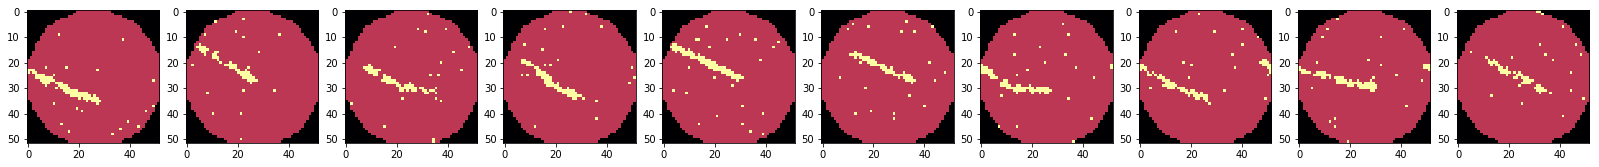

In [350]:
fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(28, 20))
ax = ax.ravel(order='C')
for i in range(10):
    ax[i-10].imshow(df_scratch_curved.waferMap[i], cmap='inferno')

plt.show() 

# Генератор колец 

In [37]:
def create_rings(XC, YC, R_, PHI, N, pattern_type, lam_poisson=1.2):
    size = XC.shape[0]
    df = [None] * size
    
    for n in range(size):
        ## параметры кольца
        phi = np.linspace(PHI[n][0], PHI[n][1], N[n])
        r = np.linspace(R_[n][0], R_[n][1], N[n])
        xc = XC[n]
        yc = YC[n]

        ## синтез сетки
        R, Fi = np.meshgrid(r, phi)
        X = R*(np.cos(Fi)) + xc
        Y = R*(np.sin(Fi)) + yc
        X_ = np.around(X)
        Y_ = np.around(Y)

        ## индексы для полигона
        points = []
        for i in range(X_.shape[0]):
            for j in range(X_.shape[1]):
                x = X_[i,j]
                y = Y_[i,j]
                points.append((x,y))

        ## создадим тестовый полигон
        test = cv2.resize(wafer_map.waferMap, dsize=(IMAGE_DIMS[0],IMAGE_DIMS[1]), 
                  interpolation=cv2.INTER_NEAREST) 
        ## 2 - паттерн
        ## 1 - фон
        ## 0 - область, где нет ничего
        test[test == 2] = 1
        COLOR_SCALE = 2
        
        
        for idx in points:
            i, j = idx
            i = int(round(i))
            j = int(round(j))
            try:
                if test[i,j] == 1:
                    test[i,j] = COLOR_SCALE
            except IndexError:
                break
                
        
        is_dilate = random.randint(-1,1)
        if is_dilate == 1:
            ## сверткой расширим
            kernel = np.ones((3,3), np.uint8)
            kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
            count_iter = random.randint(1,3)
            test = cv2.dilate(test,kernel,iterations = count_iter)
            test = cv2.morphologyEx(test, cv2.MORPH_CLOSE, kernel)


        ## внесем шум
        noise_img = test.copy()
        mask = np.random.randint(0, 2, size=noise_img.shape).astype(np.bool)
        mask[noise_img == 0] = False
        r = np.random.poisson(lam=lam_poisson, size=noise_img.shape)
        # нормировка на шумы
        r[r==0] = 1
        r[r>2] = 2
        noise_img[mask] = r[mask]
        

        ## сверткой расширим
        kernel = np.ones((3,3), np.uint8)
        kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
        noise_img = cv2.morphologyEx(noise_img, cv2.MORPH_CLOSE, kernel)
        noise_img = cv2.erode(noise_img,kernel,iterations = 1)
        
        df[n] = [noise_img, pattern_type]
        
    return pd.DataFrame(df, columns=['waferMap', 'failureType'])


## Rings

In [152]:
%%time
## число синтезированных карт
N_POINTS = 12

PHI = None
for i in range(4):
    ## угол старта для сектора
    phi1 = np.random.uniform(0+95*i, 40+95*i, size=N_POINTS//4) * np.pi/180
    ## угол конца для сектора
    phi2 = np.random.uniform(320+90*i, 360*(i+1), size=N_POINTS//4) * np.pi/180
    phi = np.vstack((phi1, phi2))
    ## merge под формат генератора
    phi = np.array([[phi[0,j], phi[1,j]] for j in range(phi.shape[1])])
    if i == 0:
        PHI = phi
    else:
        PHI = np.vstack((PHI, phi))

## радиус внутреннего круга
r1 = np.random.randint(0.19*IMAGE_DIMS[0], 0.21*IMAGE_DIMS[0], size=N_POINTS)
## радиус внешнего круга 
r2 = np.random.randint(0.21*IMAGE_DIMS[0], 0.28*IMAGE_DIMS[0], size=N_POINTS)
r = np.vstack((r1, r2))
## merge под формат генератора
r = np.array([[r[0,i], r[1,i]] for i in range(r.shape[1])])

## X координата старта прямой
XC = np.random.randint(0.32*IMAGE_DIMS[0], 0.55*IMAGE_DIMS[0], size=N_POINTS)
## Y координата старта прямой
YC = np.random.randint(0.32*IMAGE_DIMS[0], 0.55*IMAGE_DIMS[0], size=N_POINTS)

## интесивность
N = np.random.randint(200, 210, size=N_POINTS)

## генератор
df_donut = create_rings(XC, YC, r, PHI, N, pattern_type='Donut')

Wall time: 2.53 s


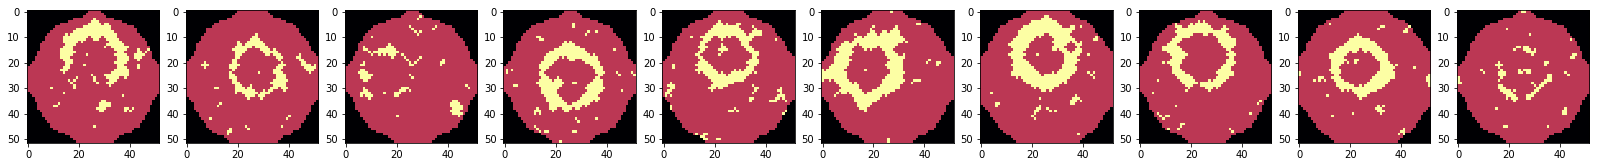

In [153]:
fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(28, 20))
ax = ax.ravel(order='C')
for i in range(10):
    ax[i-10].imshow(df_donut.waferMap[i], cmap='inferno')

plt.show() 

## Loc 

In [145]:
%%time
## число синтезированных карт
N_POINTS = 12

PHI = None
for i in range(4):
    ## угол старта для сектора
    phi1 = np.random.uniform(95*i, 55+90*i, size=N_POINTS//4) * np.pi/180
    ## угол конца для сектора
    phi2 = np.random.uniform(65+90*i, 95*(i+1), size=N_POINTS//4) * np.pi/180
    phi = np.vstack((phi1, phi2))
    ## merge под формат генератора
    phi = np.array([[phi[0,j], phi[1,j]] for j in range(phi.shape[1])])
    if i == 0:
        PHI = phi
    else:
        PHI = np.vstack((PHI, phi))

## радиус внутреннего круга
r1 = np.random.randint(0.3*IMAGE_DIMS[0], 0.33*IMAGE_DIMS[0], size=N_POINTS)
## радиус внешнего круга 
r2 = np.random.randint(0.4*IMAGE_DIMS[0], 0.45*IMAGE_DIMS[0], size=N_POINTS)
r = np.vstack((r1, r2))
## merge под формат генератора
r = np.array([[r[0,i], r[1,i]] for i in range(r.shape[1])])

## X координата старта прямой
XC = np.random.randint(0.45*IMAGE_DIMS[0], 0.55*IMAGE_DIMS[0] , size=N_POINTS)
## Y координата старта прямой
YC = np.random.randint(0.45*IMAGE_DIMS[0], 0.55*IMAGE_DIMS[0], size=N_POINTS)

## интесивность
N = np.random.randint(200, 210, size=N_POINTS)

## генератор
df_loc = create_rings(XC, YC, r, PHI, N, pattern_type='Loc')

Wall time: 2.63 s


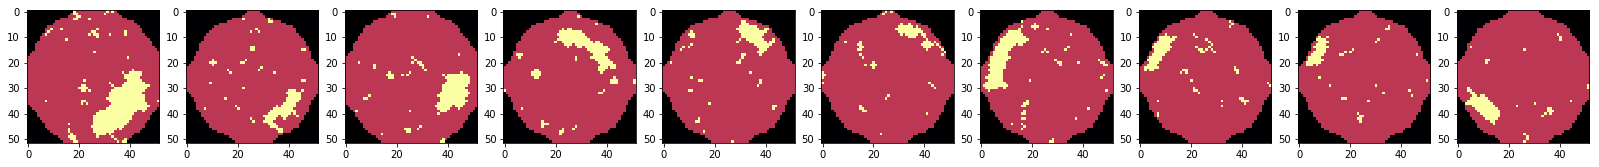

In [146]:
fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(28, 20))
ax = ax.ravel(order='C')
for i in range(10):
    ax[i-10].imshow(df_loc.waferMap[i], cmap='inferno')

plt.show() 

## Center 

In [228]:
%%time
## число синтезированных карт
N_POINTS = 12

PHI = None
for i in range(4):
    ## угол старта для сектора
    phi1 = np.random.uniform(95*i, 10+90*i, size=N_POINTS//4) * np.pi/180
    ## угол конца для сектора
    phi2 = np.random.uniform(45+90*i, 95*(i+1), size=N_POINTS//4) * np.pi/180
    phi = np.vstack((phi1, phi2))
    ## merge под формат генератора
    phi = np.array([[phi[0,j], phi[1,j]] for j in range(phi.shape[1])])
    if i == 0:
        PHI = phi
    else:
        PHI = np.vstack((PHI, phi))

## радиус внутреннего круга
r1 = np.random.randint(0.0*IMAGE_DIMS[0], 0.05*IMAGE_DIMS[0], size=N_POINTS)
## радиус внешнего круга 
r2 = np.random.randint(0.2*IMAGE_DIMS[0], 0.23*IMAGE_DIMS[0], size=N_POINTS)
r = np.vstack((r1, r2))
## merge под формат генератора
r = np.array([[r[0,i], r[1,i]] for i in range(r.shape[1])])

## X координата старта прямой
XC = np.random.randint(0.48*IMAGE_DIMS[0], 0.52*IMAGE_DIMS[0], size=N_POINTS)
## Y координата старта прямой
YC = np.random.randint(0.48*IMAGE_DIMS[0], 0.52*IMAGE_DIMS[0], size=N_POINTS)

## интесивность
N = np.random.randint(200, 210, size=N_POINTS)

## генератор
df_center = create_rings(XC, YC, r, PHI, N, pattern_type='Center')

Wall time: 2.42 s


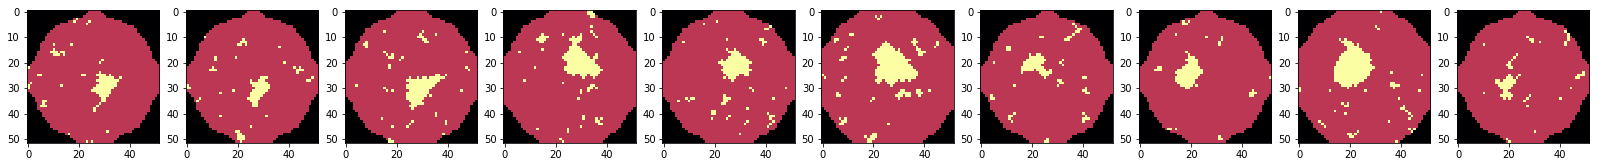

In [229]:
fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(28, 20))
ax = ax.ravel(order='C')
for i in range(10):
    ax[i-10].imshow(df_center.waferMap[i], cmap='inferno')

plt.show() 

## Random sky

In [234]:
%%time
## число синтезированных карт
N_POINTS = 12

PHI = None
for i in range(4):
    ## угол старта для сектора
    phi1 = np.random.uniform(95*i, 10+90*i, size=N_POINTS//4) * np.pi/180
    ## угол конца для сектора
    phi2 = np.random.uniform(45+90*i, 95*(i+1), size=N_POINTS//4) * np.pi/180
    phi = np.vstack((phi1, phi2))
    ## merge под формат генератора
    phi = np.array([[phi[0,j], phi[1,j]] for j in range(phi.shape[1])])
    if i == 0:
        PHI = phi
    else:
        PHI = np.vstack((PHI, phi))

## радиус внутреннего круга
r1 = np.random.randint(0.0, 1.0, size=N_POINTS)
## радиус внешнего круга 
r2 = np.random.randint(0.2*IMAGE_DIMS[0], 0.23*IMAGE_DIMS[0], size=N_POINTS)
r = np.vstack((r1, r2))
## merge под формат генератора
r = np.array([[r[0,i], r[1,i]] for i in range(r.shape[1])])

## X координата старта прямой
XC = np.random.randint(0.32*IMAGE_DIMS[0], 0.55*IMAGE_DIMS[0], size=N_POINTS)
## Y координата старта прямой
YC = np.random.randint(0.32*IMAGE_DIMS[0], 0.55*IMAGE_DIMS[0], size=N_POINTS)

## интесивность
N = np.random.randint(200, 210, size=N_POINTS)

## генератор
df_sky = create_rings(XC, YC, r, PHI, N, pattern_type='Sky')

Wall time: 2.52 s


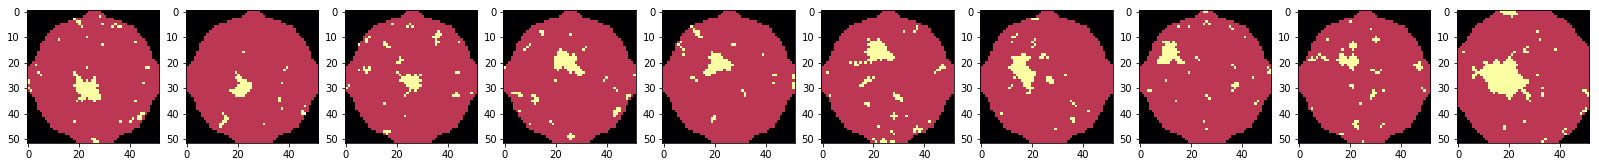

In [235]:
fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(28, 20))
ax = ax.ravel(order='C')
for i in range(10):
    ax[i-10].imshow(df_sky.waferMap[i], cmap='inferno')

plt.show() 

## Edge-Ring 

In [279]:
%%time
## число синтезированных карт
N_POINTS = 12

PHI = None
for i in range(4):
    ## угол старта для сектора
    phi1 = np.random.uniform(0+90*i, 30+90*i, size=N_POINTS//4) * np.pi/180
    ## угол конца для сектора
    phi2 = np.random.uniform(320+90*i, 360*(i+1), size=N_POINTS//4) * np.pi/180
    phi = np.vstack((phi1, phi2))
    ## merge под формат генератора
    phi = np.array([[phi[0,j], phi[1,j]] for j in range(phi.shape[1])])
    if i == 0:
        PHI = phi
    else:
        PHI = np.vstack((PHI, phi))

center = 0.5*IMAGE_DIMS[0]
r1 = np.random.randint(center-4, center-3, size=N_POINTS)
r2 = np.random.randint(center, center+1, size=N_POINTS)
r = np.vstack((r1, r2))
r = np.array([[r[0,i], r[1,i]] for i in range(r.shape[1])])

## X координата старта прямой
XC = np.random.randint(center-2, center, size=N_POINTS)
## Y координата старта прямой
YC = np.random.randint(center-2, center, size=N_POINTS)

## интесивность
N = np.random.randint(200, 210, size=N_POINTS)

## генератор
df_edge_ring = create_rings(XC, YC, r, PHI, N, pattern_type='Edge-Ring')

Wall time: 2.74 s


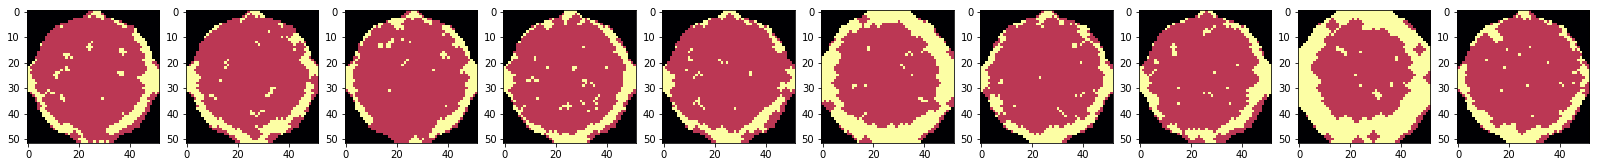

In [280]:
fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(28, 20))
ax = ax.ravel(order='C')
for i in range(10):
    ax[i-10].imshow(df_edge_ring.waferMap[i], cmap='inferno')

plt.show() 

## Edge-Loc 

In [315]:
%%time
## число синтезированных карт
N_POINTS = 12

PHI = None
for i in range(4):
    ## угол старта для сектора
    phi1 = np.random.uniform(15+90*i, 25+90*i, size=N_POINTS//4) * np.pi/180
    ## угол конца для сектора
    phi2 = np.random.uniform(55+90*i, 115+90*i, size=N_POINTS//4) * np.pi/180
    phi = np.vstack((phi1, phi2))
    ## merge под формат генератора
    phi = np.array([[phi[0,j], phi[1,j]] for j in range(phi.shape[1])])
    if i == 0:
        PHI = phi
    else:
        PHI = np.vstack((PHI, phi))

center = 0.5*IMAGE_DIMS[0]
r1 = np.random.randint(center-5, center-3, size=N_POINTS)
r2 = np.random.randint(center, center+1, size=N_POINTS)
r = np.vstack((r1, r2))
r = np.array([[r[0,i], r[1,i]] for i in range(r.shape[1])])

## X координата старта прямой
XC = np.random.randint(center-2, center-1, size=N_POINTS)
## Y координата старта прямой
YC = np.random.randint(center-2, center-1, size=N_POINTS)

## интесивность
N = np.random.randint(200, 210, size=N_POINTS)

## генератор
df_edge_loc = create_rings(XC, YC, r, PHI, N, pattern_type='Edge-Loc')

Wall time: 2.72 s


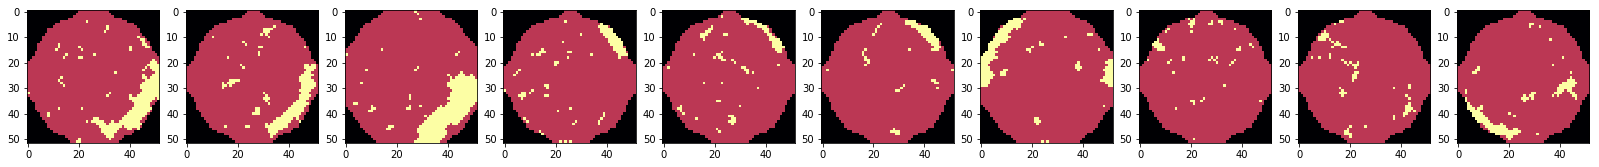

In [316]:
fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(28, 20))
ax = ax.ravel(order='C')
for i in range(10):
    ax[i-10].imshow(df_edge_loc.waferMap[i], cmap='inferno')

plt.show() 

## Near-full

In [317]:
def create_near_full(N, pattern_type, lam_poisson=1.2):
    df = [None] * N
    for n in range(N):
        ## создадим тестовый полигон
        test = cv2.resize(wafer_map.waferMap, dsize=(IMAGE_DIMS[0],IMAGE_DIMS[1]), 
                  interpolation=cv2.INTER_NEAREST) 
        ## 2 - паттерн
        ## 1 - фон
        ## 0 - область, где нет ничего
        test[test == 2] = 1
        COLOR_SCALE = 2

        ## внесем шум
        noise_img = test.copy()
        mask = np.random.randint(0, 2, size=noise_img.shape).astype(np.bool)
        mask[noise_img == 0] = False
        r = np.random.poisson(lam=lam_poisson, size=noise_img.shape)
        # нормировка на шумы
        # r = np.around(r//np.max(r))
        r[r==0] = 1
        r[r==1] = 2
        r[r>2] = 1
        noise_img[mask] = r[mask]
        

        ## сверткой расширим
        kernel = np.ones((3,3), np.uint8)
        kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
        noise_img = cv2.morphologyEx(noise_img, cv2.MORPH_CLOSE, kernel)
        noise_img = cv2.erode(noise_img,kernel,iterations = 1)

        df[n] = [noise_img, pattern_type]
        
    return pd.DataFrame(df, columns=['waferMap', 'failureType'])

In [318]:
## число синтезированных карт
N_POINTS = 12
df_near_full = create_near_full(N_POINTS, pattern_type='Near-full', lam_poisson=0.2)

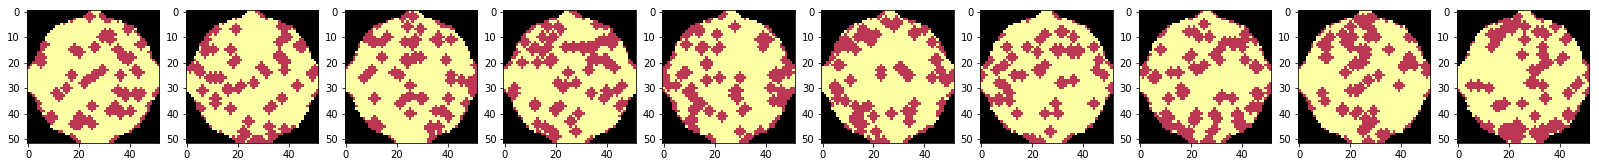

In [319]:
fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(28, 20))
ax = ax.ravel(order='C')
for i in range(10):
    ax[i-10].imshow(df_near_full.waferMap[i], cmap='inferno')

plt.show() 

## Random

In [324]:
def create_random(N, pattern_type, lam_poisson=1.2):
    df = [None] * N
    for n in range(N):
        ## создадим тестовый полигон
        test = cv2.resize(wafer_map.waferMap, dsize=(IMAGE_DIMS[0],IMAGE_DIMS[1]), 
                  interpolation=cv2.INTER_NEAREST) 
        ## 2 - паттерн
        ## 1 - фон
        ## 0 - область, где нет ничего
        test[test == 2] = 1
        COLOR_SCALE = 2

        ## внесем шум
        noise_img = test.copy()
        mask = np.random.randint(0, 2, size=noise_img.shape).astype(np.bool)
        mask[noise_img == 0] = False
        r = np.random.poisson(lam=lam_poisson, size=noise_img.shape)
        # нормировка на шумы
        # r = np.around(r//np.max(r))
        r[r==0] = 1
        r[r>2] = 2
        noise_img[mask] = r[mask]
        

        ## сверткой расширим
        kernel = np.ones((3,3), np.uint8)
        kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
        noise_img = cv2.morphologyEx(noise_img, cv2.MORPH_CLOSE, kernel)
        noise_img = cv2.erode(noise_img,kernel,iterations = 1)

        df[n] = [noise_img, pattern_type]
        
    return pd.DataFrame(df, columns=['waferMap', 'failureType'])

In [347]:
## число синтезированных карт
N_POINTS = 12
df_random = create_random(N_POINTS, pattern_type='Random', lam_poisson=2.1)

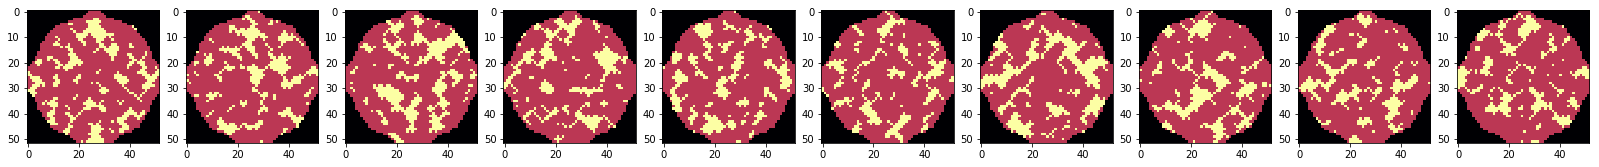

In [348]:
fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(28, 20))
ax = ax.ravel(order='C')
for i in range(10):
    ax[i-10].imshow(df_random.waferMap[i], cmap='inferno')

plt.show() 

## Объеденить все классы и сохранить

In [354]:
df = pd.concat([df_center, df_donut, df_edge_loc,
               df_edge_ring, df_loc, df_near_full,
               df_random, df_scratch_curved], sort=False)

mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,
              'Edge-Ring':3,'Loc':4,'Random':5,
              'Scratch':6,'Near-full':7}

df['failureNum'] = df.failureType
df = df.replace({'failureNum':mapping_type})

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 0 to 14
Data columns (total 3 columns):
waferMap       99 non-null object
failureType    99 non-null object
failureNum     99 non-null int64
dtypes: int64(1), object(2)
memory usage: 3.1+ KB


Loc
4


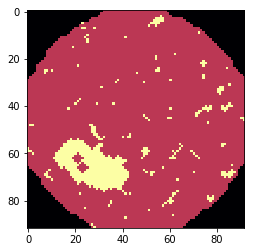

In [35]:
df.to_pickle('output/syntesis_df')

n = 9556
plt.imshow(df.waferMap.values[n],cmap='inferno')
print(df.failureType.values[n])
print(df.failureNum.values[n])

## Проверка

In [315]:
df_test = pd.read_pickle('output/syntesis_df')

Edge-Ring


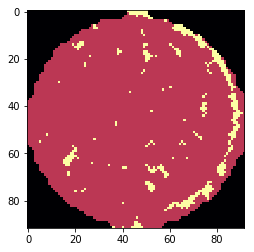

In [277]:
n = 4531
plt.imshow(df_test.waferMap.values[n],cmap='inferno')
print(df_test.failureType.values[n])

## Параллельное вычисление карт 

In [ ]:
from multiprocessing import cpu_count
cpu_count = cpu_count()
from joblib import Parallel, delayed

n_workers = cpu_count
%time 
scores = Parallel(n_workers)(delayed(f2_from_fnames)(pred_files[i::n_workers]) for i in range(n_workers))
scores = sum(scores)
print(scores/sample_size)